<a href="https://colab.research.google.com/github/albogdan/aps360-project/blob/cnn/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import shutil
torch.manual_seed(42069)

In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
if os.path.exists(os.path.expanduser('~/data')):
    !rm -rf {os.path.expanduser('~/data')}
  
!unzip '/content/gdrive/My Drive/Skule/!Year 3/S20 - APS360 (Intro to AI)/APS360 Project/kaggle_dataset/separate_dataset.zip' -d {os.path.expanduser('~/data')}

In [ ]:
# location on Google Drive
raw_path = '/root/data/separate_dataset'
master_path = '/root/data'
# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])


In [ ]:
def get_data_loaders(batch_size=32):
    dataset = torchvision.datasets.ImageFolder(raw_path, transform=transform)

    DATASET_SIZE = len(dataset)

    trainset, validset, testset = torch.utils.data.random_split(dataset, [int(0.6*DATASET_SIZE), int(0.2*DATASET_SIZE), int(0.2*DATASET_SIZE)])

    num_workers = 4

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    
    return train_loader, valid_loader, test_loader
    
train_loader, valid_loader, test_loader = get_data_loaders(batch_size=32)

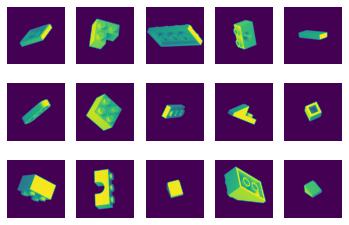

In [ ]:
# Visualization
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0].squeeze(0)
    # place the colour channel at the end, instead of at the beginning
    #img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = image / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [ ]:
# Model
# Try transfer learning with inceptionnet or resnet
# Validation acc: 0.6401
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.name = "initial"
#         self.conv1 = nn.Conv2d(1, 5, 5, padding=3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(5, 10, 5, padding=1)
#         self.fc1 = nn.Linear(10*55*55,200)
#         self.fc2 = nn.Linear(200, 100)
#         self.fc3 = nn.Linear(100, 50)

#     def forward(self, x):
#         x = self.pool(F.leaky_relu(self.conv1(x)))
#         x = self.pool(F.leaky_relu(self.conv2(x)))
#         x = x.view((-1,10*55*55))
#         x = F.leaky_relu(self.fc1(x))
#         x = F.leaky_relu(self.fc2(x))
#         x = F.leaky_relu(self.fc3(x))
#         return x

# Validation acc: 0.6670
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "initial"
        self.conv1 = nn.Conv2d(1, 5, 5, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5, padding=1)
        self.fc1 = nn.Linear(10*55*55,400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view((-1,10*55*55))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        return x

net = Net()
summary(net, (1,224,224),device="cpu")

!nvidia-smi


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 226, 226]             130
         MaxPool2d-2          [-1, 5, 113, 113]               0
            Conv2d-3         [-1, 10, 111, 111]           1,260
         MaxPool2d-4           [-1, 10, 55, 55]               0
            Linear-5                  [-1, 400]      12,100,400
            Linear-6                  [-1, 200]          80,200
            Linear-7                  [-1, 100]          20,100
            Linear-8                   [-1, 50]           5,050
Total params: 12,207,140
Trainable params: 12,207,140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 3.61
Params size (MB): 46.57
Estimated Total Size (MB): 50.37
----------------------------------------------------------------
Thu Jul  9 02:34:44 2020       
+-

In [ ]:
# Training functions

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{}_bs{}_lr{}_epoch{}".format(name, 
                                                batch_size,
                                                learning_rate,
                                                epoch)
    return path

def evaluate(model, dataloader, criterion):
    eval_mod = model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader,0):
            imgs, labels = data
            imgs = imgs.cuda()
            labels = labels.cuda()
            output = eval_mod(imgs)

            #select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
            total_loss += criterion(output, labels).item()
            
    total_acc = correct / total
    return total_acc, total_loss

def train(net, learning_rate, batch_size, epochs):
    torch.manual_seed(1000)
    
    # Get data loaders
    train_loader, val_loader, test_loader = get_data_loaders(batch_size)

    # Optimizer setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)

    # Initialize error and loss tracking arrays
    train_acc = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    val_acc = np.zeros(epochs)
    val_loss = np.zeros(epochs)


    start_time = time.time()
    # Train
    for epoch in range(epochs):
        epoch_total_preds = 0
        epoch_correct_preds = 0
        epoch_loss = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            pred = outputs.max(1, keepdim=True)[1]
            epoch_correct_preds += pred.eq(labels.view_as(pred)).sum().item()
            epoch_total_preds += inputs.shape[0]
            
        train_acc[epoch] = epoch_correct_preds / epoch_total_preds
        train_loss[epoch] = epoch_loss
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print(("Epoch {}: Train acc: {:.4f}, Train loss: {:.4f} |"+
              "Validation acc: {:.4f}, Validation loss: {:.4f} | Time: {}").format(
                  epoch + 1,
                  train_acc[epoch],
                  train_loss[epoch],
                  val_acc[epoch],
                  val_loss[epoch],
                  time.time()-start_time))
        
        # Save the current model to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training in {:.2f} seconds'.format(time.time()-start_time))
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
net = Net().cuda()
train(net, 0.0005, 32, 30)

Epoch 1: Train acc: 0.2230, Train loss: 1985.6095 |Validation acc: 0.3415, Validation loss: 503.2950 | Time: 110.87399172782898
Epoch 2: Train acc: 0.4072, Train loss: 1332.7978 |Validation acc: 0.4681, Validation loss: 399.1801 | Time: 221.78500080108643
Epoch 3: Train acc: 0.5058, Train loss: 1079.3140 |Validation acc: 0.5321, Validation loss: 348.8335 | Time: 332.5328440666199
Epoch 4: Train acc: 0.5823, Train loss: 909.0245 |Validation acc: 0.5753, Validation loss: 308.4140 | Time: 443.6103575229645
Epoch 5: Train acc: 0.6372, Train loss: 773.5446 |Validation acc: 0.5843, Validation loss: 311.2967 | Time: 554.7113163471222
Epoch 6: Train acc: 0.6864, Train loss: 663.9037 |Validation acc: 0.6079, Validation loss: 287.5717 | Time: 665.5757732391357
Epoch 7: Train acc: 0.7392, Train loss: 554.8612 |Validation acc: 0.6362, Validation loss: 285.2199 | Time: 777.7026505470276
Epoch 8: Train acc: 0.7795, Train loss: 474.4566 |Validation acc: 0.6391, Validation loss: 297.5202 | Time: 889.2

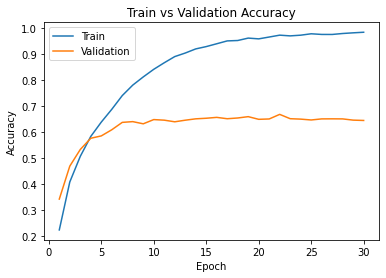

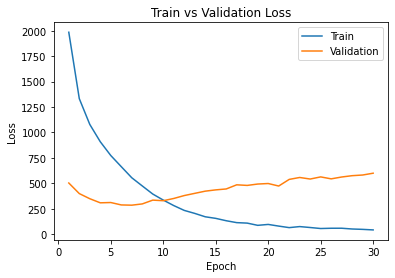

In [ ]:
plot_training_curve(get_model_name("initial", batch_size=32, learning_rate=0.0005, epoch=29))

In [ ]:
# Small dataset to see if can overfit

def get_small_loader(batch_size):
  
    dataset = torchvision.datasets.ImageFolder(raw_path,
                                              transform=transform)
    
    num_workers = 4
    picks = np.random.permutation(1000)
    subset = torch.utils.data.Subset(dataset, picks)

    small_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, 
                            shuffle=True, num_workers=num_workers)
    return small_loader


def small_train(net, learning_rate, batch_size, epochs):
    torch.manual_seed(1000)
    torch.cuda.manual_seed(1000)
    np.random.seed(1000)

    train_loader = get_small_loader(batch_size)

    # Optimizer setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)

    # Initialize error and loss tracking arrays
    train_acc = np.zeros(epochs)
    train_loss = np.zeros(epochs)

    start_time = time.time()
    # Train
    for epoch in range(epochs):
        epoch_total_preds = 0
        epoch_correct_preds = 0
        epoch_loss = 0
        for inputs,labels in iter(train_loader):
            print(labels)
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()
            pred = outputs.max(1, keepdim=True)[1]
            epoch_correct_preds += pred.eq(labels.view_as(pred)).sum().item()
            epoch_total_preds += inputs.shape[0]
            
        train_acc[epoch] = epoch_correct_preds / epoch_total_preds
        train_loss[epoch] = epoch_loss
        if epoch % 1 == 0:
            print(("Epoch {}: Train acc: {:.4f}, Train loss: {:.4f}").format(
                  epoch + 1,
                  train_acc[epoch],
                  train_loss[epoch]))
        
    print(("Epoch {}: Train acc: {:.4f}, Train loss: {:.4f}").format(
            epoch + 1,
            train_acc[epoch],
            train_loss[epoch]))
    for i in range(len(labels)):
        if pred[i] != labels[i]:
            print(outputs[i])
            print(net(inputs[i].view((1,3,224,224))))
            print(labels[i])
    print('Finished Training in {:.2f} seconds'.format(time.time()-start_time))

net = Net().cuda()
small_train(net, 0.005, 32,300)

smallset_loader = get_small_loader(batch_size=32)

RuntimeError: ignored